<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Load-the-model" data-toc-modified-id="Load-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the model</a></span></li><li><span><a href="#Refit-the-model-on-all-the-data" data-toc-modified-id="Refit-the-model-on-all-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Refit the model on all the data</a></span></li><li><span><a href="#Prediction-of-customers'-response-to-the-last-marketing-champaign" data-toc-modified-id="Prediction-of-customers'-response-to-the-last-marketing-champaign-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prediction of customers' response to the last marketing champaign</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Modeling

We can now use final model to predict the customers response to the last marketing champaign, and gain insights into what are the significant features to influence customers to make respond or not.

 ## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from library.sb_utils import save_file


## Load the model

In [2]:
expected_model_version = '1.0'
model_path = '../models/customer_analysis_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## Refit the model on all the data

In [3]:
df = pd.read_csv('./Data/03_Preprocessed.csv')
df.head()

,ID,Income,Age,Children,Days_Enrolled,TotalExpenses,TotalAcceptedCmp5,TotalNumPurchases,Education,Marital_Status,AcceptedCmp6
0,5524,58138.0,58,0,997,1617,0,25,1,1,1
1,2174,46344.0,61,2,151,27,0,6,1,1,0
2,4141,71613.0,50,0,498,776,0,21,1,0,0
3,6182,26646.0,31,1,91,53,0,8,1,0,0
4,5324,58293.0,34,1,347,422,0,19,0,0,0


In [4]:
X = df.drop(['ID', 'AcceptedCmp6'], axis=1)
y = df['AcceptedCmp6']

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
len(X), len(y)

(2152, 2152)

In [6]:
model.fit(X,y)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', None),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

In [7]:
cv_results = cross_validate(model, X, y, scoring='roc_auc', cv=5, n_jobs=-1)

In [8]:
cv_results

{'fit_time': array([0.15655327, 0.18251204, 0.17353678, 0.16356254, 0.17450619]),
 'score_time': array([0.00897574, 0.00997353, 0.00897646, 0.00899124, 0.01296544]),
 'test_score': array([0.8097966 , 0.84385637, 0.83724609, 0.81239199, 0.84682824])}

In [9]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(-0.8300238574211176, 0.01578550688385605)

These numbers are different to those in the previous step that used a different training data set. They should, however, be consistent.
It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

In [10]:
y_pred = model.predict(X)

[[1821    3]
 [  19  309]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1824
           1       0.99      0.94      0.97       328

    accuracy                           0.99      2152
   macro avg       0.99      0.97      0.98      2152
weighted avg       0.99      0.99      0.99      2152



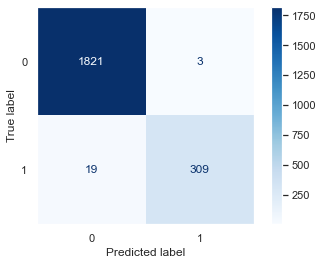

In [11]:
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

cf = confusion_matrix(y,y_pred)
cmd = ConfusionMatrixDisplay(cf)
cmd.plot(cmap='Blues')
plt.grid(False)
plt.show();

ROC_AUC: 0.9994918699186992


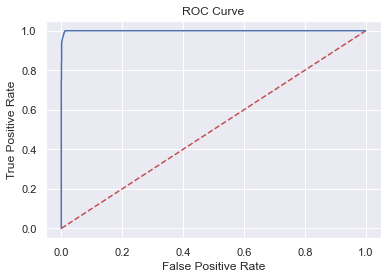

In [12]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X)[:,1]

# Compute and print AUC score
print("ROC_AUC: {}".format(roc_auc_score(y, y_pred_prob)))

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show();

## Prediction of customers' response to the last marketing champaign 

**Features that came up as important in the modeling (not just final random forest model) included:**
 - 'Income'
 - 'Days_Enrolled'
 - 'TotalExpenses'
 - 'TotalAcceptedCmp5' - total accepted responses except the last champaign
 - 'Age'
 - 'Marital Status'
 - 'Education'

In terms of Income:
Active customers have higher income compare to that of no-response customers.

In terms of days_enrolled:
Loyal customers are highly responsive as they engaged with company for longer period of time.

In terms of Expenses:
Customers with more expenses are more responsive.

In terms of total number of champaign:
Customers with more responses to the first 5 champaign are more active to the last one

In terms of Age: 
Age of these active customer are between 25 to 75. 

In terms of Marital_status:
Couples are slightly more active compare to single people.

In terms of Education:
customers with UG backgroud are least active to the last champaign.


## Conclusion 

 - To solve this binary classification problem, I performed supervised machine learning, trained 5 classification models. After comparing and evaluating the model performance, the final random forest model is selected and further used to predict customers' response to the last champaign based. The model has overall average accuracy of 0.99 and the True Positive Rate 0.94, and perform well on the dataset.

 - The analysis of customers' family structures, income and spending behaviors and train the machine learning model can help business better plan marketing strategies. Further analysis of the purchased products and locations may generate more insights from the data.